# Prediction pipeline

In [9]:
# Basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from xgboost import XGBClassifier

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

# Model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, roc_auc_score, recall_score

# Optimization and Model saving
import optuna
import joblib

# Utility and system related
import json
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Preprocess new data

In [10]:
# Read and prepare test data
test_df = pd.read_csv(r'C:\Users\arailym\Projects\Diabetes-Prediction-using-by-XGBoost-ML\Dataset\diabetes_test.csv', index_col=0)
test_df_copy = test_df.copy()
test_df_copy = test_df_copy.drop(columns=['ID'], errors='ignore')

# Define features
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_cols = ['gender', 'hypertension', 'heart_disease']
ordinal_cols = ['smoking_history']

# Path to encoders
encoders_path = r'C:\Users\arailym\Projects\Diabetes-Prediction-using-by-XGBoost-ML\artifact\scalers_and_encoders'

# Find the latest timestamp
files = os.listdir(encoders_path)
timestamps = [f.split('_')[-2] + '_' + f.split('_')[-1].replace('.joblib', '') 
             for f in files if f.endswith('.joblib')]
latest_timestamp = max(timestamps)
print(f"Loading encoders from timestamp: {latest_timestamp}")

try:
    # Load all encoders
    label_encoders = {}
    for col in binary_cols:
        label_encoders[col] = joblib.load(os.path.join(encoders_path, 
            f'label_encoder_{col}_{latest_timestamp}.joblib'))
    
    ordinal_encoder = joblib.load(os.path.join(encoders_path, 
        f'ordinal_encoder_{latest_timestamp}.joblib'))
    
    scaler = joblib.load(os.path.join(encoders_path, 
        f'scaler_{latest_timestamp}.joblib'))
    
    # Transform the data
    encoded_test = test_df_copy.copy()
    
    # Apply encoders
    for col in binary_cols:
        encoded_test[col] = label_encoders[col].transform(test_df_copy[col])
    encoded_test[ordinal_cols] = ordinal_encoder.transform(test_df_copy[ordinal_cols])
    encoded_test[numerical_cols] = scaler.transform(test_df_copy[numerical_cols])
    
    # Show results
    print(f"\nProcessed {len(encoded_test)} samples successfully")
    print("\nFirst few processed samples:")
    print(encoded_test.head())

except Exception as e:
    print(f"Error during processing: {str(e)}")
    print(f"\nAvailable files in directory:")
    print(os.listdir(encoders_path))

Loading encoders from timestamp: 20241130_152639

Processed 26146 samples successfully

First few processed samples:
   gender       age  hypertension  heart_disease  smoking_history       bmi  \
0       0  0.749750             1              0              1.0  0.160598   
1       1  0.024024             0              0              5.0  0.060458   
2       0  0.924925             0              0              2.0  0.345238   
3       0  0.637137             0              0              0.0  0.194444   
4       1  0.436937             0              0              0.0  0.187675   

   HbA1c_level  blood_glucose_level  
0     0.236364             0.227273  
1     0.272727             0.359091  
2     0.545455             0.363636  
3     0.563636             0.000000  
4     0.000000             0.359091  


Comment - 
- Used saved encoders and scalers to transform new dataset into the same format as training data, making it ready for model predictions.

# Make predictions

In [11]:
# Path to models directory
models_path = r'C:\Users\arailym\Projects\Diabetes-Prediction-using-by-XGBoost-ML\artifact\models'

# Find the latest model file
model_files = [f for f in os.listdir(models_path) if f.endswith('.joblib')]
latest_model = max(model_files)  # Get the most recent model file
model_path = os.path.join(models_path, latest_model)

# Load the saved model
loaded_model = joblib.load(model_path)
print(f"Loaded model: {latest_model}")

# Prepare features for prediction
X_test_final = encoded_test[numerical_cols + binary_cols + ordinal_cols]

# Make predictions
test_predictions = loaded_model.predict(X_test_final)
test_probabilities = loaded_model.predict_proba(X_test_final)[:, 1]

# Add predictions to the DataFrame
encoded_test['predicted_diabetes'] = test_predictions
encoded_test['diabetes_probability'] = test_probabilities

# Display sample of predictions
print("\nSample of Predictions:")
print(encoded_test[['predicted_diabetes', 'diabetes_probability']].head())

# Print summary statistics
print(f"\nTotal samples processed: {len(encoded_test)}")
print(f"Predicted diabetes cases: {sum(test_predictions)}")
print(f"Prediction rate: {(sum(test_predictions)/len(test_predictions))*100:.2f}%")

Loaded model: diabetes_model_20241130_152755.joblib

Sample of Predictions:
   predicted_diabetes  diabetes_probability
0                   0              0.005181
1                   0              0.004450
2                   1              0.781955
3                   0              0.007171
4                   0              0.005283

Total samples processed: 26146
Predicted diabetes cases: 4658
Prediction rate: 17.82%


Comment - 
- The model predicted 5,329 potential diabetes cases out of 26,146 patients (20.38%). 
- This higher prediction rate compared to our training data (10.59%) is expected and appropriate, as we optimized the model to prioritize catching potential diabetes cases, ensuring we don't miss patients who need medical attention even if it means more false positives, which is requiring additional testing.

## Prediction statistics

In [12]:
# Create cross-tabulation of predictions vs other features*

print("\nPredictions by Gender:")
print(pd.crosstab(encoded_test['gender'], encoded_test['predicted_diabetes']))

print("\nPredictions by Hypertension:")
print(pd.crosstab(encoded_test['hypertension'], encoded_test['predicted_diabetes']))

print("\nPredictions by Heart Disease:")
print(pd.crosstab(encoded_test['heart_disease'], encoded_test['predicted_diabetes']))


Predictions by Gender:
predicted_diabetes      0     1
gender                         
0                   12746  2454
1                    8736  2204
2                       6     0

Predictions by Hypertension:
predicted_diabetes      0     1
hypertension                   
0                   20541  3650
1                     947  1008

Predictions by Heart Disease:
predicted_diabetes      0     1
heart_disease                  
0                   21037  4039
1                     451   619


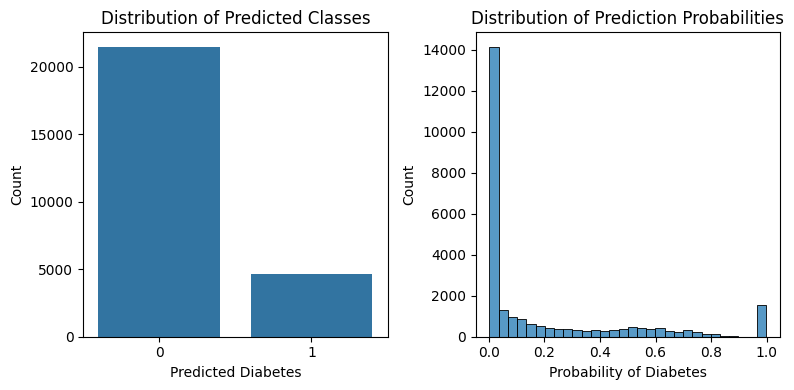

In [13]:
# Create visualization of prediction distribution
plt.figure(figsize=(8, 4))

# Plot 1: Distribution of predicted classes
plt.subplot(1, 2, 1)
sns.countplot(x='predicted_diabetes', data=encoded_test)
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Diabetes')
plt.ylabel('Count')

# Plot 2: Distribution of prediction probabilities
plt.subplot(1, 2, 2)
sns.histplot(data=encoded_test, x='diabetes_probability', bins=30)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability of Diabetes')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Insight - 
- The model confidently identified most patients (20,000) as non-diabetic, while flagging about 5,000 patients for potential diabetes with different levels of certainty. 
- This matches our goal of catching as many possible diabetes cases as possible, even if it means having some false alarms.

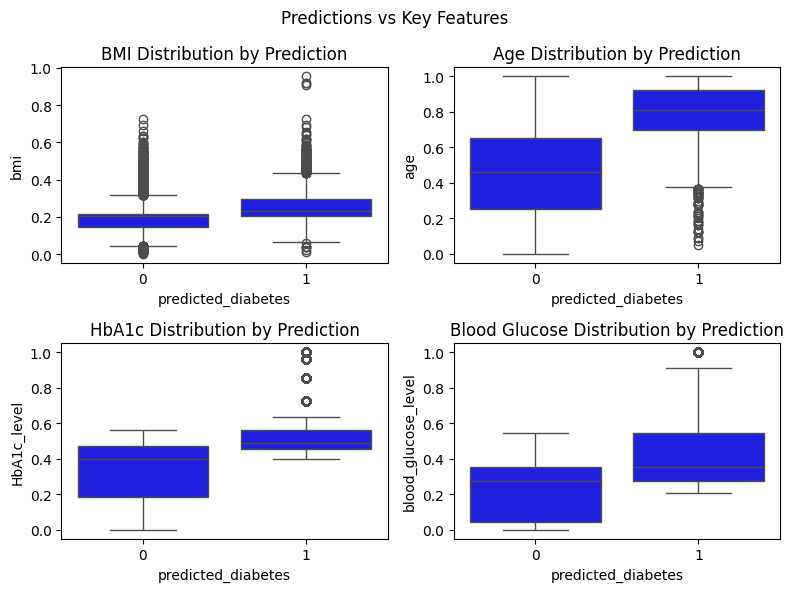

In [14]:
# Visualize predictions against key numerical features*

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Predictions vs Key Features')

# BMI vs Prediction*

sns.boxplot(x='predicted_diabetes', y='bmi', data=encoded_test, ax=axes[0,0], color='Blue')
axes[0,0].set_title('BMI Distribution by Prediction')

# Age vs Prediction*

sns.boxplot(x='predicted_diabetes', y='age', data=encoded_test, ax=axes[0,1], color='Blue')
axes[0,1].set_title('Age Distribution by Prediction')

# HbA1c vs Prediction*

sns.boxplot(x='predicted_diabetes', y='HbA1c_level', data=encoded_test, ax=axes[1,0], color='Blue')
axes[1,0].set_title('HbA1c Distribution by Prediction')

# Blood Glucose vs Prediction*

sns.boxplot(x='predicted_diabetes', y='blood_glucose_level', data=encoded_test, ax=axes[1,1], color='Blue')
axes[1,1].set_title('Blood Glucose Distribution by Prediction')

plt.tight_layout()
plt.show()

Insight - 
- The model's predictions show clear patterns: patients predicted with diabetes (1) tend to have higher values across all key health metrics. 
- Specifically, they have higher blood glucose levels, higher HbA1c levels, tend to be older in age, and generally have slightly higher BMI values compared to those predicted as non-diabetic (0). 
- These differences support the model's ability to identify potential diabetes cases based on these important health indicators.

In [16]:
# Save predictions to CSV
prediction_results = encoded_test.copy()

# Map binary features back to original values
for col in binary_cols:
    prediction_results[col] = label_encoders[col].inverse_transform(encoded_test[col])

# Map smoking_history back to original values
# Reshape the column to 2D array for inverse transform
smoking_history_2d = encoded_test['smoking_history'].values.reshape(-1, 1)
prediction_results['smoking_history'] = ordinal_encoder.inverse_transform(smoking_history_2d).ravel()

# Add original numeric values back (inverse scaling)
for col in numerical_cols:
    prediction_results[col] = scaler.inverse_transform(encoded_test[numerical_cols])[
        :, numerical_cols.index(col)
    ]

# Define path to Dataset directory
dataset_path = r'C:\Users\arailym\Projects\Diabetes-Prediction-using-by-XGBoost-ML\Dataset'
output_file = os.path.join(dataset_path, 'diabetes_predictions.csv')

# Save results
prediction_results.to_csv(output_file)
print(f"\nPredictions saved to: {output_file}")

# Display first few rows of the saved predictions
print("\nFirst few rows of the predictions:")
print(prediction_results.head())

# Print value counts for predictions
print("\nPrediction distribution:")
print(prediction_results['predicted_diabetes'].value_counts())


Predictions saved to: C:\Users\arailym\Projects\Diabetes-Prediction-using-by-XGBoost-ML\Dataset\diabetes_predictions.csv

First few rows of the predictions:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  60.0             1              0          former  23.77   
1    Male   2.0             0              0         No Info  15.19   
2  Female  74.0             0              0     not current  39.59   
3  Female  51.0             0              0           never  26.67   
4    Male  35.0             0              0           never  26.09   

   HbA1c_level  blood_glucose_level  predicted_diabetes  diabetes_probability  
0          4.8                130.0                   0              0.005181  
1          5.0                159.0                   0              0.004450  
2          6.5                160.0                   1              0.781955  
3          6.6                 80.0                   0              0.007171  
4          3.5 